# Does AI can recognize feelings?
Major / Minor chords calssification

## Importing the relevant directories

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pywt
import sys
import os
import math
from scipy.io import wavfile
from numpy.fft import fft
from sklearn.cluster import DBSCAN
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold


from collections import Counter


%matplotlib inline


## Generating the file list

In [4]:
path=r'C:\Users\kobi_z\Documents\Data Science\Chords Tracks'

In [5]:
file_name=[]
for folder in os.listdir(path):
    dir_path=os.path.join(path,folder)
    for file in os.listdir(dir_path):
        file_path=os.path.join(dir_path,file)
        file_name.append([file_path,folder])

## Feature Eng.
### 1. FFT in order to find out the most dominant frq.
### 2. Interval between 2 frq.
### 3. Anomaly detection by DBSCAN

In [6]:
data=[]
for i,file in enumerate(file_name):
    fs, snd = wavfile.read(file_name[i][0])
    y=np.mean( np.array([snd[:,0],snd[:,1]]), axis=0 ) # averaging both channels of streo
    n = len(y) 
    p = fft(y) 
    mag = np.sqrt(p.real**2 + p.imag**2)
    mag = mag * 2 / n
    mag = mag[0:math.ceil((n)/2.0)] # since it's symetric due to niquist point
    freq = np.arange(0, len(mag), 1.0) * (fs / n)
    
    threshold=min(np.sort(mag)[-20:])-10
    frq_array=np.unique(np.rint(freq[np.in1d(mag, mag[mag>threshold])]))
    frq_array=frq_array[frq_array<1000]
     
    X=frq_array
    clustering = DBSCAN(eps=7, min_samples=2).fit(X.reshape(-1,1))
    
    main_frq=[]
    a=clustering.components_.flatten()
    b=clustering.labels_
    b=b[b!=-1]
    my_counter = Counter(b)
    cnt=my_counter.most_common(3)
    for i,clust in enumerate(cnt):
        index=np.argwhere(b==clust[0])
        frq=a[index]
        main_frq.append(frq)
        

    main_frq=np.concatenate(main_frq, axis=0)
    main_frq=np.sort(main_frq).flatten()
    main_frq.sort()
    
    c=math.log(pow(2,1/12),10)
    n=[math.log(main_frq[i+1]/main_frq[i],10)/c for i in range(len(main_frq)-1)]
    
    diff=[]
    [diff.append(round(i,3)) for i in n if np.abs(i)>0.5]
    data.append([file[0].split('\\')[7].split(' ')[0],file[1],file[0].split('\\')[7].split(' ')[1].split('.')[0],len(snd),diff,len(diff)])


## Review the data frame

In [7]:
df=pd.DataFrame(data)
df.columns=['Chord','Class','Ver','Len','features','Len_Diff']
pd.set_option('display.max_rows', None)
df['Class_cat']=preprocessing.LabelEncoder().fit(df['Class']).transform(df['Class'])
df['x1']=df['features'].map(lambda x:x[0])
df['x2']=df['features'].map(lambda x:x[1])

df

,Chord,Class,Ver,Len,features,Len_Diff,Class_cat,x1,x2
0,A,Major,v1,80112,"[3.879, 2.902]",2,0,3.879,2.902
1,A,Major,v2,85072,"[4.889, 3.847]",2,0,4.889,3.847
2,A,Major,v3,79280,"[7.786, 3.879]",2,0,7.786,3.879
3,A#,Major,v1,78800,"[3.863, 2.901]",2,0,3.863,2.901
4,A#,Major,v2,93904,"[4.919, 3.893]",2,0,4.919,3.893
5,A#,Major,v3,87760,"[2.86, 4.919]",2,0,2.860,4.919
6,B,Major,v1,78512,"[3.947, 2.849]",2,0,3.947,2.849
7,B,Major,v2,83920,"[4.875, 3.947]",2,0,4.875,3.947
8,B,Major,v3,84800,"[7.845, 3.891]",2,0,7.845,3.891
9,C,Major,v1,66176,"[3.876, 2.84]",2,0,3.876,2.840


## Defining the features & class for model training

In [8]:
features=df[['x1','x2']].values
CLASS=df['Class_cat'].to_numpy()

# SVC Model

In [9]:
pipeline=Pipeline(steps=[('scaler', StandardScaler()),('svm',SVC(gamma='auto'))])
grid_param={'svm__C':[5,10,15,20,25,30], 'svm__kernel': ['rbf','linear','poly','sigmoid','precomputed'],'svm__degree' : [1,2,3,5,8],'svm__max_iter': [3,5,7,100,150]}

In [10]:
gd_sr = GridSearchCV(estimator=pipeline,
                     param_grid=grid_param,
                     scoring='accuracy',
                     cv=5,
                     n_jobs=-1)

In [11]:
gd_sr.fit(features, CLASS)

C:\Users\kobi_z\Anaconda3\envs\tensorflowCPU\lib\site-packages\sklearn\svm\_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('svm', SVC(gamma='auto'))]),
             n_jobs=-1,
             param_grid={'svm__C': [5, 10, 15, 20, 25, 30],
                         'svm__degree': [1, 2, 3, 5, 8],
                         'svm__kernel': ['rbf', 'linear', 'poly', 'sigmoid',
                                         'precomputed'],
                         'svm__max_iter': [3, 5, 7, 100, 150]},
             scoring='accuracy')

In [12]:
print(gd_sr.best_params_)
print('The best score found is: ',round(gd_sr.best_score_,3))

{'svm__C': 20, 'svm__degree': 1, 'svm__kernel': 'rbf', 'svm__max_iter': 100}
The best score found is:  0.679


# Decisoin Tree Model

In [13]:
pipeline2=Pipeline(steps=[('scaler', StandardScaler()),('class',DecisionTreeClassifier())])
grid_param2={'class__criterion': ['gini','entropy'], 'class__min_samples_split': [2,3,4,5]}

In [14]:
gd_sr2 = GridSearchCV(estimator=pipeline2,
                     param_grid=grid_param2,
                     scoring='accuracy',
                     cv=5,
                     n_jobs=-1)

In [15]:
gd_sr2.fit(features, CLASS)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('class', DecisionTreeClassifier())]),
             n_jobs=-1,
             param_grid={'class__criterion': ['gini', 'entropy'],
                         'class__min_samples_split': [2, 3, 4, 5]},
             scoring='accuracy')

In [16]:
print(gd_sr2.best_params_)
print('The best score found is: ',round(gd_sr2.best_score_,3))

{'class__criterion': 'gini', 'class__min_samples_split': 2}
The best score found is:  0.778


# Bagging Classifier

In [37]:
pipeline3=Pipeline(steps=[('scaler', StandardScaler()),('class',BaggingClassifier())])
grid_param3={'class__n_estimators': [5,10,15], 'class__max_samples': [5,10,15,20],'class__max_features':[1,2,3]}
gd_sr3 = GridSearchCV(estimator=pipeline3,
                     param_grid=grid_param3,
                     scoring='accuracy',
                     cv=5,
                     n_jobs=-1)

In [38]:
gd_sr3.fit(features, CLASS)
print(gd_sr3.best_params_)
print('The best score found is: ',round(gd_sr3.best_score_,3))

{'class__max_features': 2, 'class__max_samples': 20, 'class__n_estimators': 10}
The best score found is:  0.679


# Random Forest 

In [46]:
pipeline4=Pipeline(steps=[('scaler', StandardScaler()),('class',RandomForestClassifier())])
grid_param4={'class__n_estimators': [10,50,100,150,200,250,300], 'class__min_samples_split': [2,3,4,5],'class__criterion':['gini','entropy']}
gd_sr4 = GridSearchCV(estimator=pipeline4,
                     param_grid=grid_param4,
                     scoring='accuracy',
                     cv=5,
                     n_jobs=-1)

In [47]:
gd_sr4.fit(features, CLASS)
print(gd_sr4.best_params_)
print('The best score found is: ',round(gd_sr4.best_score_,3))

{'class__criterion': 'entropy', 'class__min_samples_split': 2, 'class__n_estimators': 50}
The best score found is:  0.777


# Plotting the Signal

In [16]:
fs, snd = wavfile.read(file_name[13][0])
y=snd[:,0]
n = len(y) 
p = fft(y) 
mag = np.sqrt(p.real**2 + p.imag**2)
mag = mag * 2 / n
mag = mag[0:math.ceil((n)/2.0)] # since it's symetric due to niquist point
freq = np.arange(0, len(mag), 1.0) * (fs / n)

threshold=min(np.sort(mag)[-20:])-10
print(threshold)

frq_array=np.unique(np.rint(freq[np.in1d(mag, mag[mag>threshold])]))
frq_array=frq_array[frq_array<1000]

59.66578467208946


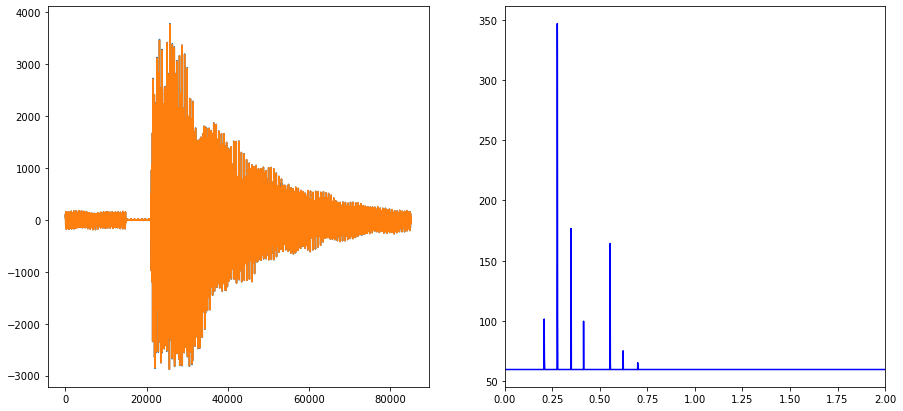

In [17]:
fig=plt.figure(figsize=(15,7))

ax1=fig.add_subplot(122)
if threshold != 0:
    #ind1- getting true / false accordign to both arrays equal numbers
    #rint  - rount the the nearst integer
    #unique - return the unique values (like set)
    X=np.unique(np.rint(freq[np.in1d(mag, mag[mag>threshold])]))
    mag[mag<threshold]=threshold

ax1.set_xlim([0,2])
ax1=plt.plot(freq/1000, mag, color='b')

ax2=fig.add_subplot(121)
ax2=plt.plot(snd)


plt.show()

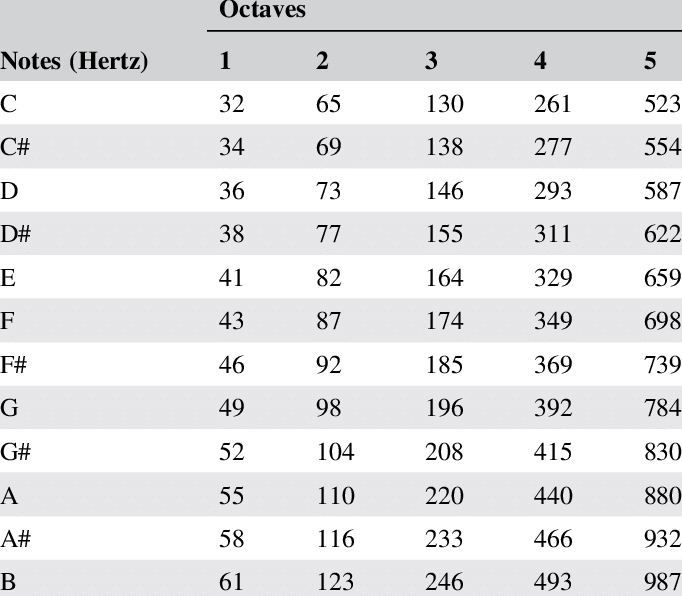